In [ ]:
import numpy as np

namedtuple
experiment_configs = [#{"device_name": ["GeForce GTX TITAN Black"],
                      #  "f_name": ["f_layer_complex_neuron"],
                      #  "n_neurons_l0": np.arange(32, 1024, 32),
                      #  "n_inputs": np.arange(32, 1024, 32),
                      #  "mults_per_thread": [1],
                      #  "neurons_per_wrg": [0]},
                      {"device_name": ["GeForce GTX TITAN Black"],
                        "f_name": ["f_layer_complex_neuron_local"],
                        "n_neurons_l0": np.arange(32, 1024, 32),
                        "n_inputs": np.arange(32, 1024, 32),
                        "mults_per_thread": [1],
                        "neurons_per_wrg": [0]}]
experiments_range1 = slice(0, 5)
experiments_start2 = 5
experiments_range2 = slice(experiments_start2, experiments_start2 + 2)

img_path = "/home/nm/msc_report/img"
print("hi2")

In [ ]:
import os
import pprint
import pandas as pd

def load_experiments():
    #experiment_dir = "experiment." + network_config
    results_lift = None
    i = 0
    dirs = [(".", d) for d in filter(
        lambda x: os.path.isdir(os.path.join(".", x)) and 
        x.startswith("experiment.") and 
        os.path.isdir(os.path.join(".", x, "results_lift")), 
        os.listdir("."))] + [("/home/nm/apart_results", d) for d in filter(
        lambda x: os.path.isdir(os.path.join("/home/nm/apart_results", x)) and 
        x.startswith("experiment.") and 
        os.path.isdir(os.path.join("/home/nm/apart_results", x, "results_lift")), 
        os.listdir("/home/nm/apart_results"))]
    
    for experiment_dir in dirs:
        results_lift_dir = os.path.join(experiment_dir[0], experiment_dir[1], "results_lift")
        print(experiment_dir)

        for filename in os.listdir(results_lift_dir):
            single_csv = pd.read_csv(os.path.join(results_lift_dir, filename), index_col=False)
            single_csv["datetime"] = filename[:filename.find("_")]
            single_csv["n_neurons_l0"] = int(experiment_dir[1][15:experiment_dir[1].find("-", 15)])
            if results_lift is not None:
                results_lift = results_lift.append(single_csv, ignore_index=True)                
            else:
                results_lift = single_csv
            i = i + 1
            if i % 20 == 0:
                print(".", end="")
        print()
    return results_lift

nonfiltered_results = load_experiments()
print("%d non-filtered results." % len(nonfiltered_results))

('.', 'experiment.784-230-32-10')
...............................
('.', 'experiment.784-256-32-10')
................
('.', 'experiment.784-228-32-10')
................................
('.', 'experiment.784-231-32-10')
................................
('.', 'experiment.784-224-32-10')
......................................................
('.', 'experiment.784-234-32-10')
................................
('/home/nm/apart_results', 'experiment.784-32-32-10')
..............................
('/home/nm/apart_results', 'experiment.784-64-32-10')
......................
('/home/nm/apart_results', 'experiment.784-96-32-10')
........
('/home/nm/apart_results', 'experiment.784-160-32-10')
.........
('/home/nm/apart_results', 'experiment.784-192-32-10')
........
('/home/nm/apart_results', 'experiment.784-128-32-10')
...............
('/home/nm/apart_results', 'experiment.784-1024-32-10')
.......
('/home/nm/apart_results', 'experiment.784-224-32-10')
................
('/home/nm/apart_results', 'expe

In [ ]:
def filter_experiments(experiment_configs, nonfiltered_results):
    results = []
    for config in experiment_configs:
        results.append(nonfiltered_results[np.all([k in nonfiltered_results and
                        nonfiltered_results[k].isin(vs) for k, vs in config.items()], axis=0)])
        #results.append([result for result in nonfiltered_results if matches(result, config)])
    return results

results = filter_experiments(experiment_configs, nonfiltered_results)
data_is_reset = True

print("Loaded " + str(len(results)) + " experiment(s):")
for exp_i in range(len(results)):
    print("Experiment " + str(exp_i) + ": " + str(len(results[exp_i])) + " records")

In [ ]:
# Format data
if data_is_reset:
    # Runtimes: s -> ms
    original_status = pd.options.mode.chained_assignment
    pd.options.mode.chained_assignment = None
    for result in results:
        result.loc[:, "runtime_l0"] = result["runtime_l0"].apply(lambda x: x * 1000)
        result.loc[:, "runtime_l1"] = result["runtime_l1"].apply(lambda x: x * 1000)
        result.loc[:, "runtime_l2"] = result["runtime_l2"].apply(lambda x: x * 1000)
    pd.options.mode.chained_assignment = original_status
    print ("Data was formatted.")
    data_is_reset = False

In [ ]:
def performance(df):
    if df.empty:
        return 0
    else:
        #return df["runtime_l0"]
        #return df["n_inputs"] / (df["layer_len0"] * df["runtime_l0"])
        #return df["runtime_l0"] / (df["n_inputs"] * df["layer_len0"])
        return (df["n_inputs"] * df["layer_len0"]) / df["runtime_l0"]
    
def standardize(matrices):    
    global_max = 0
    global_min = 999
    
    for i in range(len(matrices)):
        if matrices[i].max() > global_max:
            global_max = matrices[i].max()
        if matrices[i].min() < global_min:
            global_min = matrices[i].min()
    for i in range(len(matrices)):
        matrices[i] = (matrices[i] - global_min) / (global_max - global_min)
    return matrices

In [ ]:
# Prepares data
matrices = []
n_n_neurons = int(1024 / 32 - 1)
n_n_inputs = int(1056 / 32 - 1)
for experiment in results[experiments_range1]:
    matrix = np.zeros((n_n_neurons, n_n_inputs), dtype=np.float32)
    for n_neurons in np.arange(n_n_neurons):
        for n_inputs in np.arange(n_n_inputs):
            matrix[n_neurons, n_inputs] = np.nan_to_num(
                experiment[(experiment["layer_len0"] == 32 + n_neurons * 32) &
                           (experiment["n_inputs"] == 32 + n_inputs * 32)]\
                [["n_inputs", "layer_len0", "runtime_l0"]]\
                .apply(performance, axis=1).mean())
            print(".", end="")

    matrices.append(matrix)
    
matrices = standardize(matrices)

for i in range(len(matrices)):   
    print()
    matrix2 = np.zeros((matrices[i].shape[0] + 1, matrices[i].shape[1] + 1))
    matrix2[1:, 1:] = matrices[i][:, :]
    matrices[i] = matrix2#.transpose()
    print("Matrix shape:", matrix.shape)
    print("Data prepared.")

f_layer_complex_neuron
Second min: 0.158
Max: 0.1999
Mean: 0.1879
Median: 0.1912

f_layer_complex_neuron_local
Second min: 0.048
Max: 0.0699
Mean: 0.0670
Median: 0.0687

f_layer_complex_neuron_mrgd_wrgs_in_1d
Second min: 0.388
Max: 0.9537
Mean: 0.4724
Median: 0.4671

f_layer_complex_neuron_mrgd_wrgs_in_2d
Second min: 0.737
Max: 1.0000
Mean: 0.8434
Median: 0.8716

f_layer_complex_neuron_mrgd_wrgs_in_2d_coalesced
Second min: 0.737
Max: 0.9814
Mean: 0.8439
Median: 0.8715



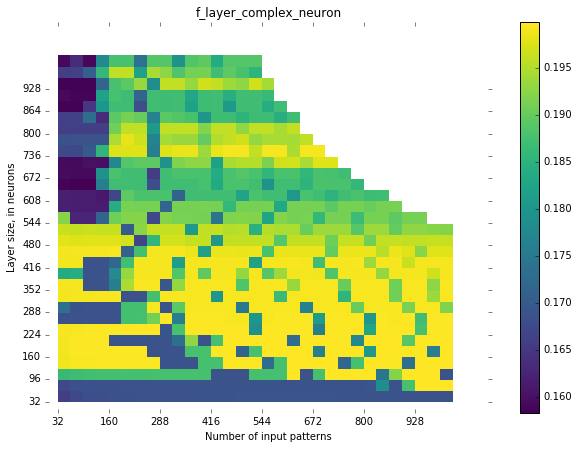

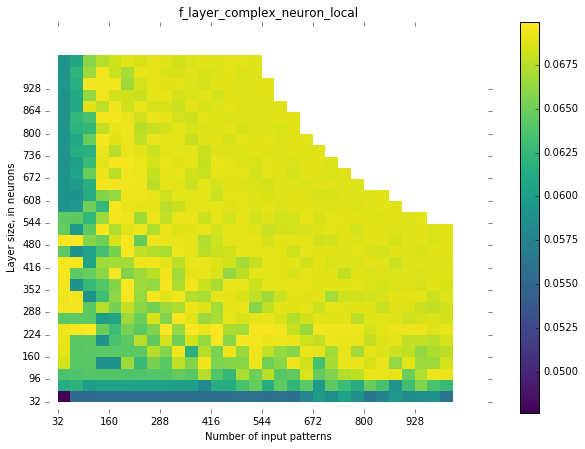

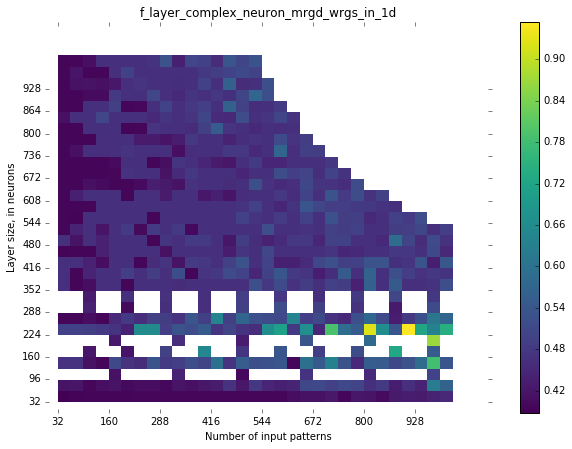

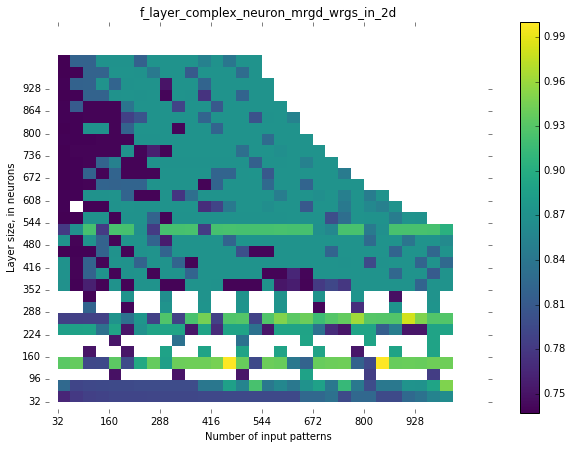

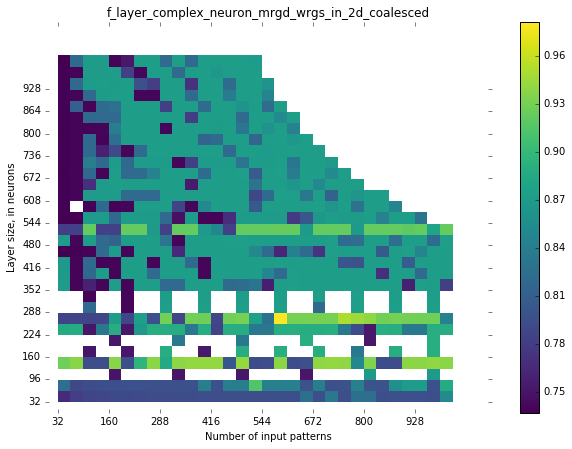

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

second_min_global = 2
max_global = 0
for matrix in matrices:
    matrix2 = np.copy(matrix)
    np.place(matrix2, matrix2 == 0, [2])
    second_min = matrix2.min()
    if second_min < second_min_global:
        second_min_global = second_min
    if matrix.max() > max_global:
        max_global = matrix.max()
    
i = 0
for matrix in matrices:
    matrix2 = np.copy(matrix)
    np.place(matrix2, matrix2 == 0, [2])
    second_min = matrix2.min()
    # Renders the plot
    fig, ax = plt.subplots()
    cmap = plt.cm.viridis
    
    heatmap = ax.pcolor(matrix, cmap=cmap, vmin=second_min, vmax=matrix.max())
    m = plt.cm.ScalarMappable(cmap=cmap)
    cmap.set_under(color="white")
    m.set_clim(vmin=second_min, vmax=matrix.max())
    m.set_array(matrix)
    plt.colorbar(m)

    ax.set_title(experiment_configs[i]["f_name"][0])
    ax.set_xlabel('Number of input patterns')
    ax.set_ylabel('Layer size, in neurons')
    ax.set_xticks(np.arange(1, n_n_inputs, 4))
    ax.set_xticklabels(np.arange(32, 1056, 32 * 4))
    ax.set_yticks(np.arange(1, n_n_neurons, 2))
    ax.set_yticklabels(np.arange(32, 1024, 32 * 2))

    # Format
    fig = plt.gcf()
    fig.set_size_inches(10, 7)
    # turn off the frame
    ax.set_frame_on(False)
    print(experiment_configs[i]["f_name"][0])
    print("Second min: %.3f" % second_min)
    matrix_nan = np.copy(matrix)
    matrix_nan[matrix_nan == 0] = np.nan
    print("Max: %.4f" % np.nanmax(matrix_nan))
    print("Mean: %.4f" % np.nanmean(matrix_nan))
    print("Median: %.4f" % np.nanmedian(matrix_nan, axis=None))
    print()
    
    plt.savefig(os.path.join(img_path, "basic_" + experiment_configs[i]["f_name"][0] + ".png"))
    i = i + 1

In [ ]:
# Prepares data 2
matrices = []

i = experiments_start2
for experiment in results[experiments_range2]:
    n_mults_per_thread = len(experiment_configs[i]["mults_per_thread"])
    n_neurons_per_wrg = len(experiment_configs[i]["neurons_per_wrg"])
    
    matrix = np.zeros((n_mults_per_thread, n_neurons_per_wrg), dtype=np.float32)
    
    for mults_per_thread in experiment_configs[i]["mults_per_thread"]:
        for neurons_per_wrg in experiment_configs[i]["neurons_per_wrg"]:
            matrix[mults_per_thread - 1, neurons_per_wrg - 1] = np.nan_to_num(
                experiment[(experiment["mults_per_thread"] == mults_per_thread) &
                           (experiment["neurons_per_wrg"] == neurons_per_wrg)]\
                [["n_inputs", "layer_len0", "runtime_l0"]]\
                .apply(performance, axis=1).mean())
            print(".", end="")

    matrices.append(matrix)
    i = i + 1
    
matrices = standardize(matrices)

for i in range(len(matrices)):   
    print()
    matrix2 = np.zeros((matrices[i].shape[0] + 1, matrices[i].shape[1] + 1))
    matrix2[1:, 1:] = matrices[i][:, :]
    matrices[i] = matrix2#.transpose()
    print("Matrix shape:", matrix.shape)
    print("Data prepared.")

f_layer_complex_neuron_mrgd_wrgs_in_2d
Second min: 0.167
Max: 1.0000
Mean: 0.5293
Median: 0.5012

f_layer_complex_neuron_mrgd_wrgs_in_2d_coalesced
Second min: 0.181
Max: 0.9594
Mean: 0.4412
Median: 0.4114



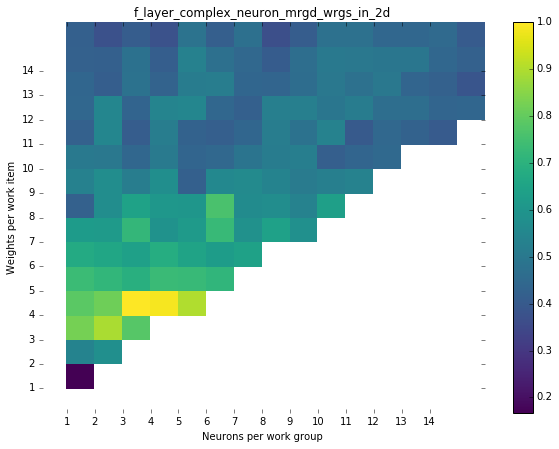

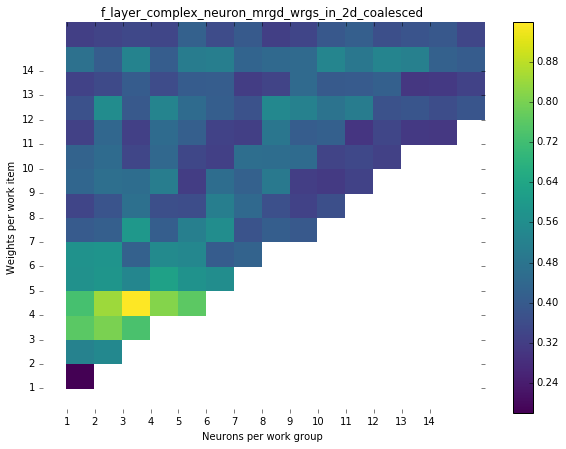

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

second_min_global = 2
for matrix in matrices:
    matrix2 = np.copy(matrix)
    np.place(matrix2, matrix2 == 0, [2])
    second_min = matrix2.min()
    if second_min < second_min_global:
        second_min_global = second_min
    
i = experiments_start2
for matrix in matrices:
    matrix2 = np.copy(matrix)
    np.place(matrix2, matrix2 == 0, [2])
    second_min = matrix2.min()
    # Renders the plot
    fig, ax = plt.subplots()
    cmap = plt.cm.viridis
    
    heatmap = ax.pcolor(matrix, cmap=cmap, vmin=second_min, vmax=matrix.max())
    m = plt.cm.ScalarMappable(cmap=cmap)
    cmap.set_under(color="white")
    m.set_clim(vmin=second_min, vmax=matrix.max())
    m.set_array(matrix)
    plt.colorbar(m)

    ax.set_title(experiment_configs[i]["f_name"][0])
    ax.set_xlabel('Neurons per work group')
    ax.set_ylabel('Weights per work item')
    
    mults_per_thread_max = experiment_configs[i]["mults_per_thread"].max()
    neurons_per_wrg_max = experiment_configs[i]["neurons_per_wrg"].max()
    
    ax.set_xticks(np.arange(1, neurons_per_wrg_max))
    ax.set_xticklabels(np.arange(1, neurons_per_wrg_max))
    ax.set_yticks(np.arange(1, mults_per_thread_max))
    ax.set_yticklabels(np.arange(1, mults_per_thread_max))

    # Format
    fig = plt.gcf()
    fig.set_size_inches(10, 7)
    # turn off the frame
    ax.set_frame_on(False)
    print(experiment_configs[i]["f_name"][0])
    print("Second min: %.3f" % second_min)
    matrix_nan = np.copy(matrix)
    matrix_nan[matrix_nan == 0] = np.nan
    print("Max: %.4f" % np.nanmax(matrix_nan))
    print("Mean: %.4f" % np.nanmean(matrix_nan))
    print("Median: %.4f" % np.nanmedian(matrix_nan, axis=None))
    print()
    plt.savefig(os.path.join(img_path, "parameterized_" + experiment_configs[i]["f_name"][0] + ".png"))
    i = i + 1